## Are velocities being rotated properly by llcreader? 

The LLC MITgcm outputs are organized such that in some tiles U is the meridional velocity instead of being the zonal velocity. 

The llcreader has a feature `faces_dataset_to_latlon` that properly roates the u, v velocities. Here we check if it works properly.


In [2]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
from intake import open_catalog

#cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")

In [4]:
# load some data from a low res model
ds  = cat["ECCOv4r3"].to_dask()
ds_ll = llcreader.llcmodel.faces_dataset_to_latlon(ds)

In [5]:
ds.attrs = {'temp':"1"}

In [6]:
ds.attrs

{'temp': '1'}

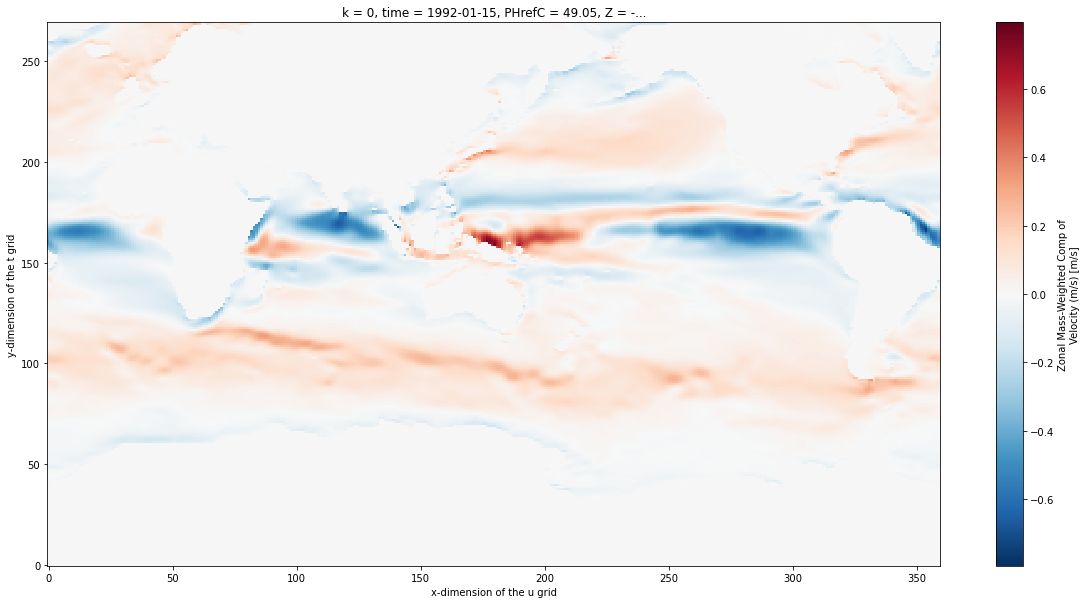

In [7]:
ds_ll.UVELMASS[0, 0].load().plot(figsize=(20, 10))

# The roation seems to be working properly in the low-res simulation.

### Does this work with the 4320?

A problem was originally noticed in the super high resolution simulation. Here we check under what circumstances this problem persists.

In [8]:
cat_4320 = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

In [9]:
u = cat_4320.LLC4320_SSU.to_dask()
v = cat_4320.LLC4320_SSV.to_dask()
coords  = cat_4320.LLC4320_grid.to_dask()

u.U.attrs = {'long_name': 'Zonal Velocity (m/s)', 
            'mate': 'V', 'units':'m/s'}
v.V.attrs = {'long_name': 'Meridional Velocity (m/s)', 
            'mate': 'U', 'units':'m/s'}

In [10]:
ds_4320 = xr.merge([u, v, coords])
ds_4320_u = xr.merge([u, coords])

In [11]:
ds_4320_ll = llcreader.llcmodel.faces_dataset_to_latlon(ds_4320, metric_vector_pairs=[])

In [16]:
ds_4320_u_ll = llcreader.llcmodel.faces_dataset_to_latlon(ds_4320_u, metric_vector_pairs=[])

ValueError: list.remove(x): x not in list

In [6]:
ds_4320_temp = xr.merge([u, coords])

In [ ]:
ds_4320_temp = xr.merge([u,v, coords])

In [9]:
ds_4320_ll = llcreader.llcmodel.faces_dataset_to_latlon(ds_4320, metric_vector_pairs=[])

In [12]:
ds_4320 = xr.merge([u, v, SST, coords])
# IS this the appropriate way to read the data? 
# Or is this loading of each variable seperately creating problems?

NameError: name 'SST' is not defined

In [28]:
ds_4320.U.attrs

{'long_name': 'Zonal Velocity (m/s)', 'mate': 'V', 'units': 'm/s'}

In [29]:
ds_4320_ll = llcreader.llcmodel.faces_dataset_to_latlon(ds_4320)
# This should have technically rotate the velocities. 

In [59]:
# Are U, V properly rotated when tranforming to lat-lon using llcreader.
# Taking some time averages, so that it is clear of eddies.

In [55]:
# How about when we plot data along a line?
Uvel_line = ds_4320_ll.U.isel(j=4100)[0:24*360:5*24,:].mean('time')
# I wanted to check if the coarsening of the grid was creating the problem.

In [ ]:
Uvel_line.load();

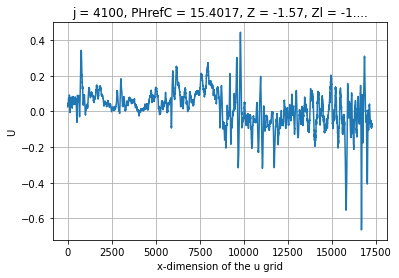

In [60]:
Uvel_line.plot()
plt.grid()
# There is some problem at ~9000. 

In [46]:
# How about when we coarsen by picking every n'th point on grid? 
# this is quite slow, but I average in time so that it is easier to 
# understand the mean direction of currents.
Utemp = ds_4320_ll.U[0:24*360:15*24, 0::96, 0::72].mean('time')
Utemp.load();
Vtemp = ds_4320_ll.V[0:24*360:5*24, 0::96, 0::72].mean('time')
Vtemp.load();

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


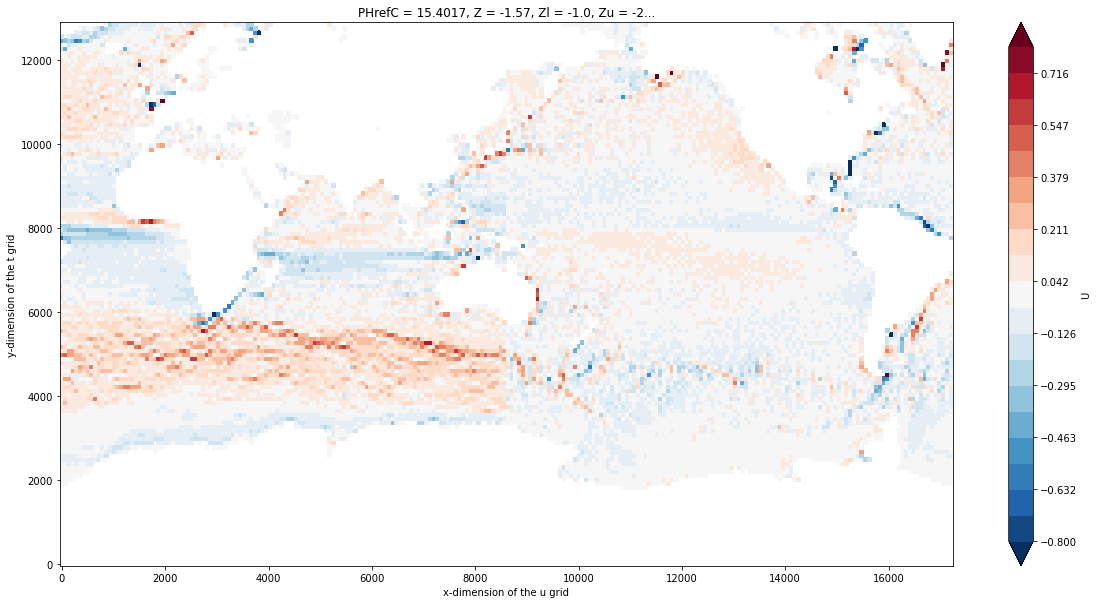

In [61]:
Utemp.plot(figsize=(20, 10), vmin=-.8, levels=20)

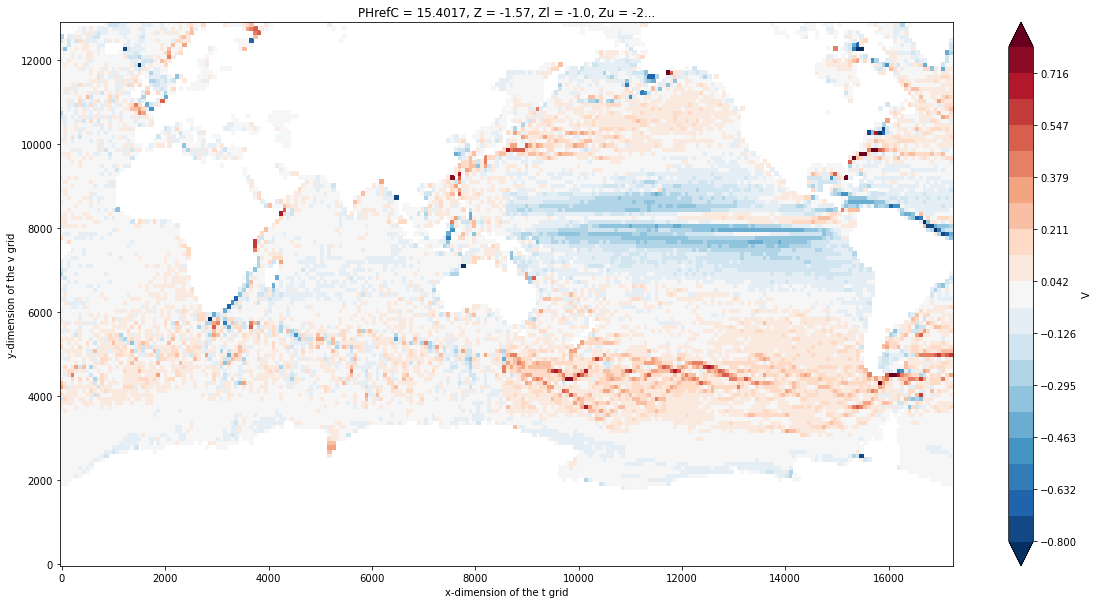

In [62]:
Vtemp.plot(figsize=(20, 10), vmin=-.8, levels=20)

In [30]:
# Does the problem persist when we use Xarray's coarsen function?
Utemp_coarsen = ds_4320_ll.U.isel(time=0).coarsen(i_g=96, j=72).mean()

In [31]:
Utemp_coarsen.load();

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Zonal velocity component from LLC4320 after projecting on to lat-lon grid')

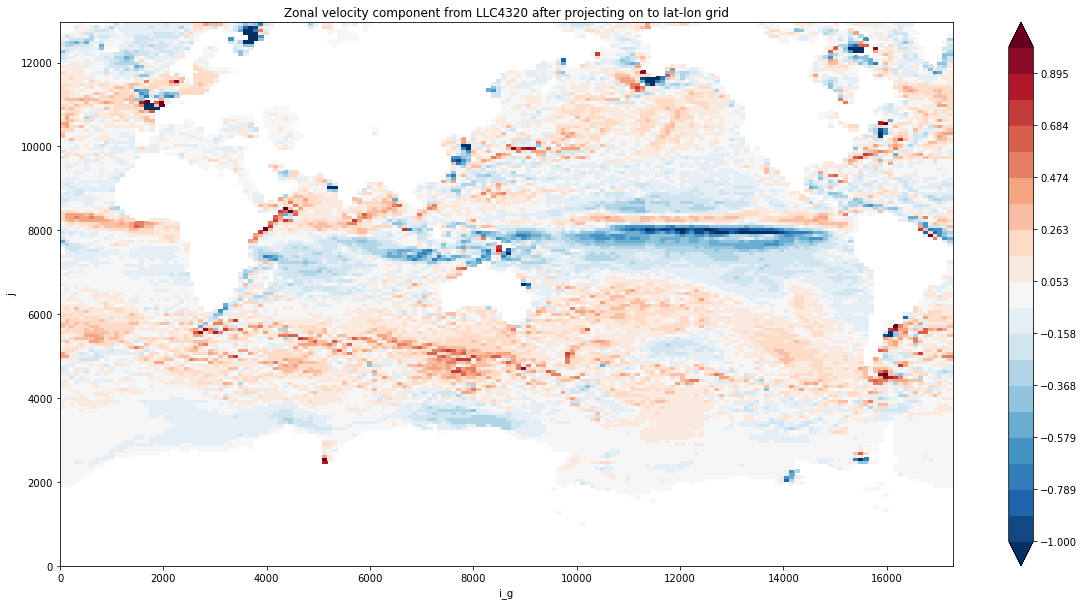

In [36]:

Utemp_coarsen.plot(figsize=(20, 10), vmin=-1, levels=20)
plt.title('Zonal velocity component from LLC4320 after projecting on to lat-lon grid')
# Same problem.

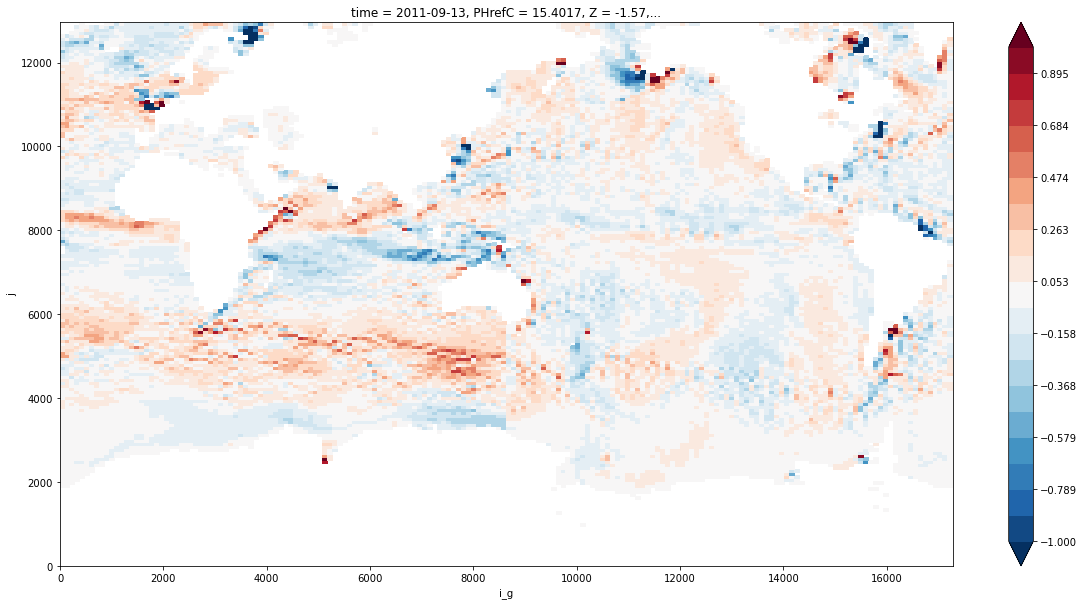

In [69]:
Utemp_coarsen.plot(figsize=(20, 10), vmin=-1, levels=20)
# Same problem.

In [ ]:
from xmitgcm import open_mdsdataset
import xarray as xr
import scipy
import numpy
import xmitgcm.llcreader.llcmodel as lm

data_dir = 'L:\2011.09.13'
grid_dir = 'N:\llc4320\grid'

prefix = ["Eta"]
ds = open_mdsdataset(data_dir, grid_dir, 
                     iters='all', prefix=prefix, read_grid=True, 
                     delta_t=1, ref_date=None, calendar='gregorian', 
                     geometry='sphericalpolar', grid_vars_to_coords=True, 
                     swap_dims=None, endian='>', chunks=None, 
                     ignore_unknown_vars=False, default_dtype=None, 
                     nx=None, ny=None, nz=None, llc_method='smallchunks', 
                     extra_metadata=None)
print(ds)
YClon = ds.YC.values
XClat = ds.XC.values
dslatlon = lm.faces_dataset_to_latlon(ds,metric_vector_pairs=[('dxC', 'dyC'), ('dyG', 'dxG')])

In [42]:
Eta = cat_4320.LLC4320_SSH.to_dask()
coords  = cat_4320.LLC4320_grid.to_dask()

In [46]:
ds = xr.merge([Eta, coords])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Z        float32 ...
    Zl       float32 ...
    Zp1      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    Zu       float32 ...
    drC      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      float32 ...
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    hFacC    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    hFacS    (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    hFacW    (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    k        int64 ...
    k_l      int64 ...
  * k_p1     (k_p1) int64 0 1
    k_u      int64 ...
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    Eta      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [45]:
ds_ll = llcreader.llcmodel.faces_dataset_to_latlon(ds, 
                metric_vector_pairs=[('dxC', 'dyC'), ('dyG', 'dxG')])

In [47]:
ds_ll

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2, time: 9030)
Coordinates:
  * k_p1     (k_p1) int64 0 1
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4017
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Z        float32 -1.57
    Zl       float32 -1.0
    Zp1      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    Zu       float32 -2.14
    drC      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      float32 1.14
    hFacC    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>